<a href="https://colab.research.google.com/github/KOISSYK/machine-learning/blob/main/5_03%ED%8A%B8%EB%A6%AC%EC%9D%98_%EC%95%99%EC%83%81%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.트리의 앙상블

* 사이킷런
1. 랜덤포레스트 
2. 엑스트라트리
3. 그라디언트부스팅
4. 히스트그램기반 그라디언트 부스팅

* 그외의 모듈
1. XGBoost
2. LightGMB(LGBM)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

wine = pd.read_csv('https://bit.ly/wine_csv_data')

data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

##랜덤포레스트(복원추출)


1. 랜덤 포레스트는 앙상블 머신러닝 모델이다. 부트스트랩 샘플사용, 다수의 의사결정 트리를 만들고, 그 나무들의 분류를 집계해서 최종적으로 분류한다. 

  부트스트랩 : 데이터 셋을 뽑을때는 복원추출(중복을 허용하여 뽑는다)을 한다는 점

2. 오버피팅을 피하기 위해 임의(random)의 숲을 구성하는 거다. 다수의 나무들로부터 분류를 집계하기 때문에 오버피팅이 나타나는 나무의 영향력을 줄일 수 있다.

3. 모든 의사결정 트리는 학습 데이터 세트에서 임의로 하위 데이터 세트를 추출하여 생성된다. 중복을 허용하기 때문에 단일 데이터가 여러번 선택될 수도 있다. 이 과정을 ***배깅(bagging)***이라고 한다.

4. 나무를 만들 때는 모든 속성(feature)들에서 임의로 일부를 선택하고 그 중 정보 획득량이 가장 높은 것을 기준으로 데이터를 분할한다. 
만약 데이터 세트에 n개의 속성이 있는 경우 n제곱근 개수만큼 무작위로 선택하는 것이 일반적이다.

* 배깅(Bagging)

  샘플을 여러 번 뽑아(Bootstrap) 각 모델을 학습시켜 결과물을 집계(Aggregration)하는 방법

  ex)학습 데이터 세트에 총 1000개의 행이 있다고 해보자. 그러면 임의로 100개씩 행을 선택해서 의사결정 트리를 만드는 게 배깅(bagging)이다


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
score = cross_validate(rf,train_input, train_target,
                       return_train_score=True, n_jobs=-1)
print(np.mean(score['train_score']),np.mean(score['test_score']))

0.9973541965122431 0.8905151032797809


In [ ]:
rf.fit(train_input, train_target)
print(rf.feature_importances_)

[0.23167441 0.50039841 0.26792718]


In [ ]:
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)

rf.fit(train_input, train_target)
print(rf.oob_score_)

0.8934000384837406


## 엑스트라트리(비복원추출)


랜덤 포레스트가 OOB 오차를 줄이기 위해 최적의 특성 조건을 설정하였다면, ***엑스트라 트리***는 무작위로 특성을 선택하여 결정 트리를 구성하는데 활용

장점 

1. 많은 트리를 앙상블하기 때문에 과대적합을 막고 검증 세트의 점수를 높이는 효과가 있다.

2. 일반적으로 엑스트라 트리는 랜덤 포레스트보다 무작위성이 조금 더 크기 때문에, 더 많은 결정 트리를 훈련해야 한다.

3. 무작위로 분할하기 때문에 속도가 빠르다

단점 

1. 결정 트리에서 특성을 무작위로 분할하게 되면 성능은 낮아진다.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_jobs=-1, random_state=42)

scores = cross_validate(et, train_input, train_target, return_train_score=True, n_jobs=-1)
#결정 트리 1000개를 모든 CPU 코어를 사용하여 훈련시키기 위해, n_jobs를 -1로 설정

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9974503966084433 0.8887848893166506


In [ ]:
et.fit(train_input,train_target)
print(et.feature_importances_)

[0.20183568 0.52242907 0.27573525]


랜덤포레스트(RandomForest) vs 엑스트라트리(Extratrees)

일반적으로 Bootstaping을 쓰지 않고, Whole origin data를 그대로 쓰는 Extratrees가 RandomForest에 비해 bias를 낮출 수 있다. 

또한 Split point를 Ramdomly하게 선택하면서 Variance를 줄일 수있다. 

연산속도도 1/3으로 줄일 수 있다.

## 그레이디언트 부스팅


* 그레이디언트 부스팅(Gradient Boosting)은 얕은 깊이의 트리를 사용하여 이전 트리의 오차를 보완하는 방식의 앙상블

* 레이디언트란 이름처럼 경사 하강법을 사용하여 앙상블에 트리를 추가하는 방식

* 모델의 가중치와 절편을 조금씩 바꿔가며, 결정 트리를 계속 추가는 방식으로 오차를 줄여간다.

* 분류에서는 ***로지스틱 손실 함수***를, 회귀에서는 ***평균 제곱 오차(MSE) 함수***를 사용


장점

그레이디언트 부스팅이 랜덤 포레스트보다 깊이가 얕은 결정 트리를 사용하기 때문에, 과대적합에 강하며 조금 더 높은 성능을 기대할 있다.

단점

오차를 줄여가는 방식으로 트리를 순서대로 추가하기 때문에, 랜덤으로 노드를 분할하는 랜덤 포레스트와 달리 훈련 속도가 느리다.



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8881086892152563 0.8720430147331015


In [ ]:
gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.2, random_state=42)

scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9464595437171814 0.8780082549788999


***그레이디언트 부스팅은 결정 트리의 개수를 늘려도 과대 적합에 매우 강하므로 학습률과 트리의 개수를 늘리면 더 높은 성능의 모델을 얻을 수도 있다***

학습률을 0.2로 설정하고 결정 트리의 개수를 500개로 늘렸음에도 과대 적합을 잘 억제하는 모습을 확인할 수 있다.

 


추가적으로, 그레이디언트 부스팅에서는 훈련에 사용할 훈련 세트 비율을 정하는 subsample이라는 매개변수가 있는데,

기본값은 1.0으로 훈련 세트를 모두 사용하지만 설정을 통해 일부 샘플을 랜덤하게 선택하는

확률적 경사 하강법이나 미니배치 경사 하강법과 비슷하게 작동시킬 수도 있다.

## 히스토그램 기반 그레이디언트 부스팅


히스토그램 기반 그레이디언트 부스팅(Histogram-based Gradient Boosting)은 정형 데이터를 다루는 머신러닝 알고리즘 중에 가장 인기가 높은 알고리즘. 
 



히스토그램 기반 그레이디언트 부스팅은 먼저 입력 특성을 256개의 구간으로 나눈다. 따라서 노드를 분할할 때 최적의 분할을 매우 빠르게 찾을 수 있다. 

 히스토그램 기반 그레이디언트 부스팅은 256개의 구간 중에서 하나를 뗴어 놓고 누락된 값을 위해서 사용한다. 따라서 입력에 누락된 특성이 있더라도 이를 따로 전처리할 필요가 없다. 

 일반적으로 HistGradientBoostingClassifier는 기본 매개변수에서 안정적인 성능을 얻을 수 있다.


In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb,train_input,train_target,
                        return_train_score=True)
print(np.mean(score['train_score']),np.mean(score['test_score']))

0.9973541965122431 0.8905151032797809


과대적합을 잘 억제하면서 그레이디언트 부스팅보다 조금 더 높은 성능을 제공한다.

 히스토그램 기반 그레이디언트 부스팅이 다양한 특성을 골고루 잘 평가한다고 예상할 수 있다.



In [ ]:
from sklearn.inspection import permutation_importance

hgb.fit(train_input, train_target)
result = permutation_importance(hgb, train_input, train_target,
                                n_repeats=10, random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.08876275 0.23438522 0.08027708]


In [ ]:
result = permutation_importance(hgb, train_input, train_target,
                                n_repeats=10, random_state=42, n_jobs=-1)
print(result.importances_mean)


[0.08876275 0.23438522 0.08027708]


In [ ]:
hgb.score(test_input,test_target)

0.8723076923076923

## XGBoost (Extreme Gradient Boosting)




```
!pip3 install xgboost

import xgboost as xgb # 파이썬 래퍼
from xgboost import XGBClassifier # 사이킷런 API

```


* XGBoost의 장점
1. GBM 대비 빠른 수행시간 

  -> 병렬 처리로 학습, 분류 속도가 빠르다.

2. 과적합 규제 지원(Regularization)

3. 분류와 회귀 task 에서 높은 예측 성능
   
   ->즉, CART(Classification and regression tree) 앙상블 모델을 사용

4. Early Stopping(조기 종료) 기능 제공

5. 다양한 옵션을 제공해 Customizing이 용이

6. 결측치를 내부적으로 처리 함

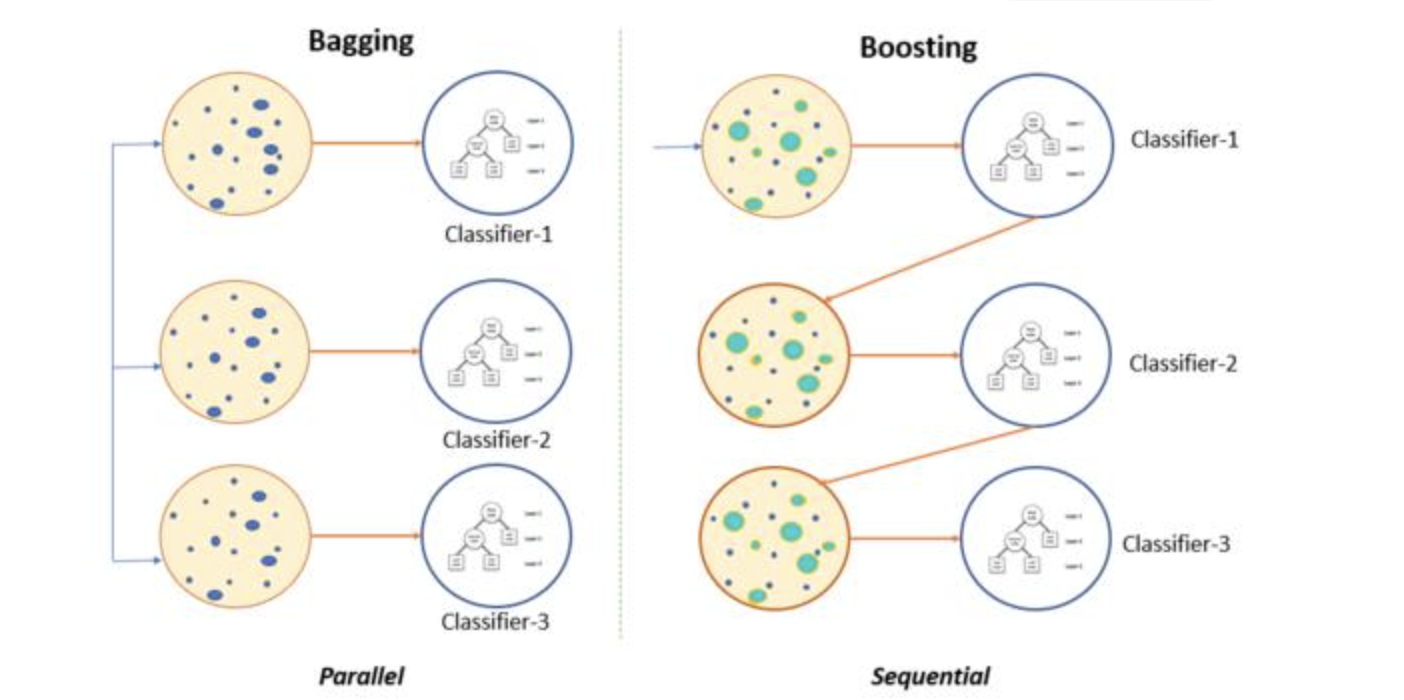

1. **시각화**

  XGBoost 모형을 시각화함으로써 개발한 예측모형의 성능에 대해 더 깊은 이해를 가질 수 있다.

2. XGBoost는 다수의 하이퍼파라미터가 존재

* 과적합문제가 심각할떄 

  learning_rate을 낮추고 n_estimators를 높여줍니다. (이 둘은 같이 움직입니다)

  max_depth 값을 낮춥니다.

  min_child_weight 값을 높입니다.

  gamma 값을 높입니다.

  subsample, colsample_bytree 값을 조정합니다.
 
https://wooono.tistory.com/97 

https://assaeunji.github.io/machine%20learning/2021-01-07-xgboost/

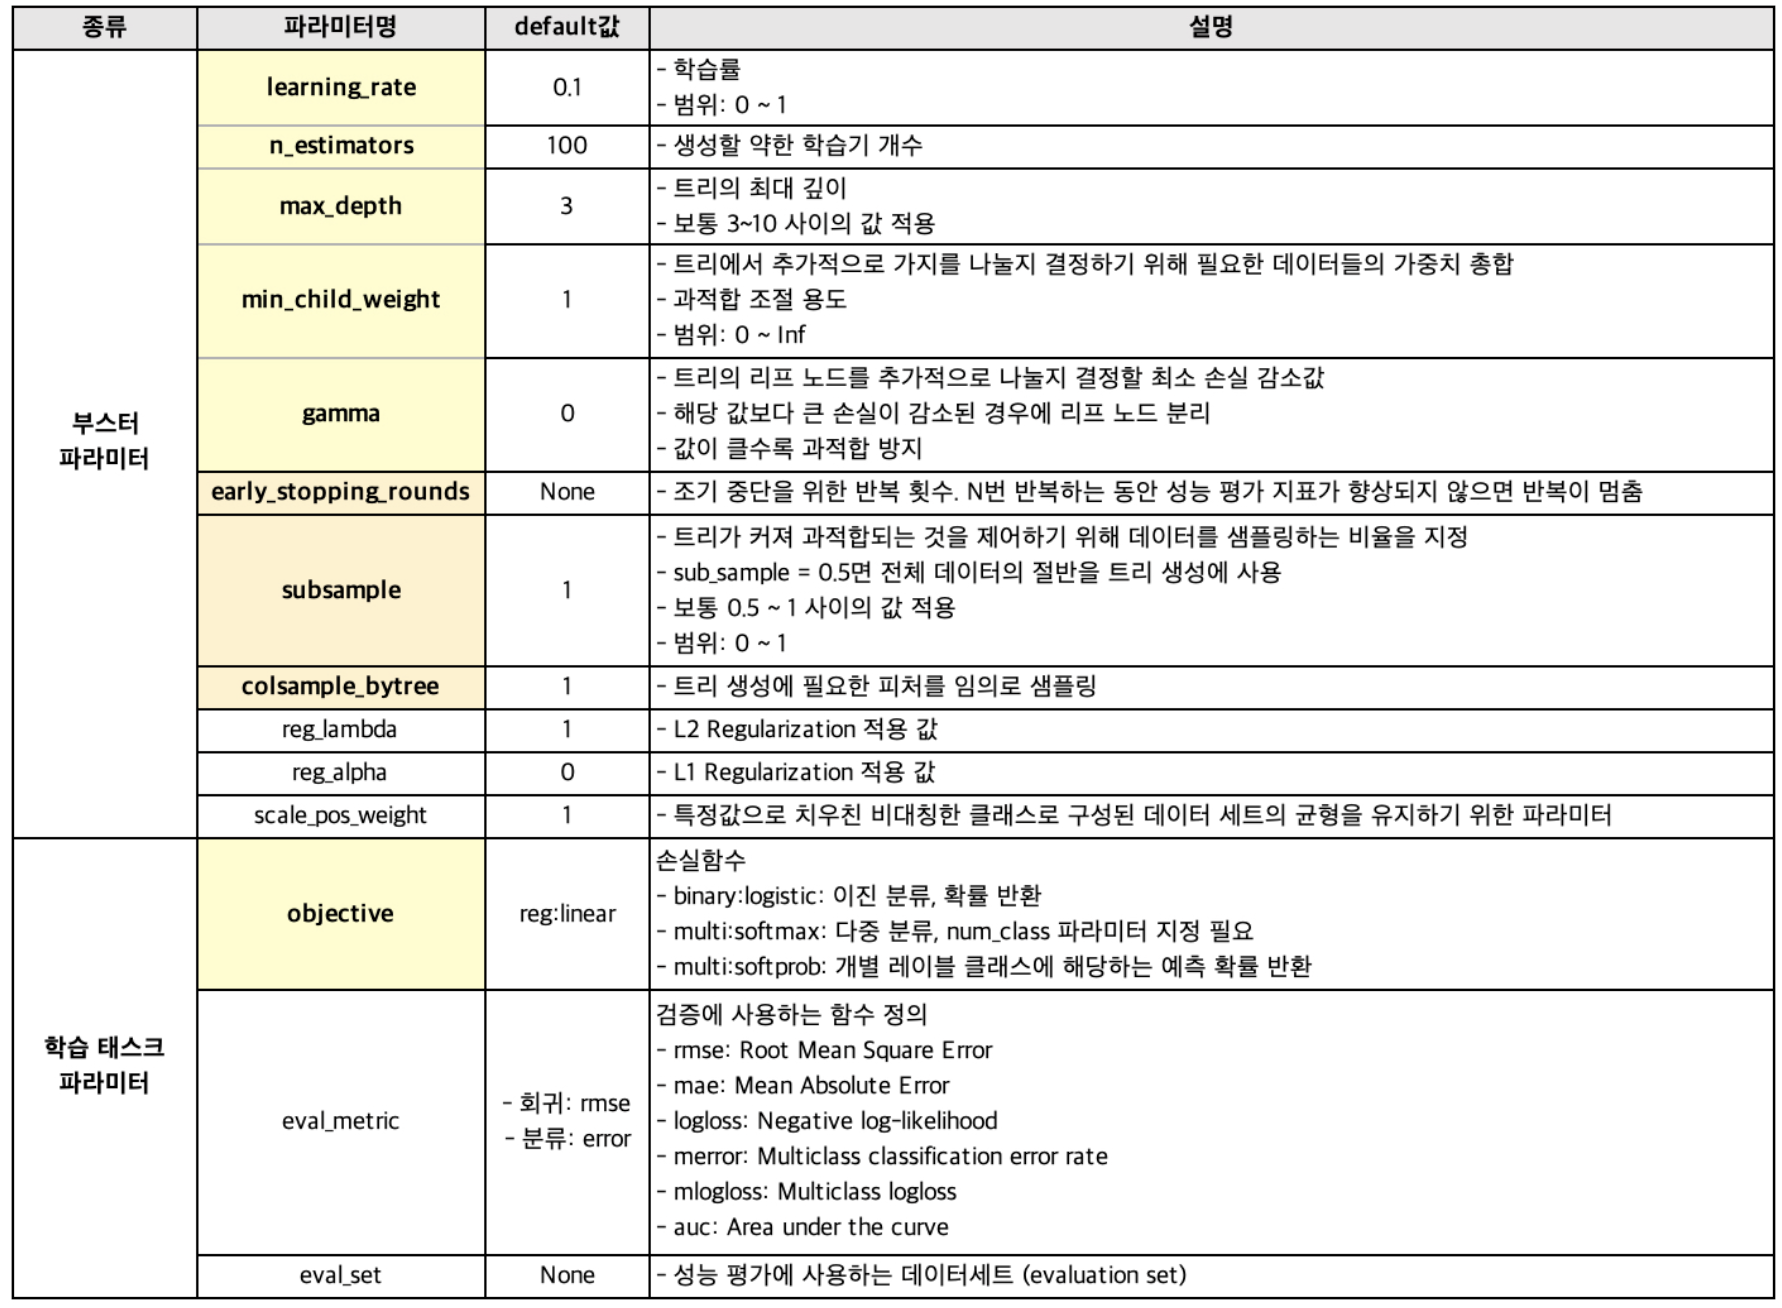

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method='hist', random_state=42)
scores = cross_validate(xgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8824322471423747 0.8726214185237284


## LightGBM

1. 장점

  Light GBM은 말 그대로 “Light” 가벼운 것인데요, 왜냐면 속도가 빠르기 때문입니다. Light GBM은 큰 사이즈의 데이터를 다룰 수 있고 실행시킬 때 적은 메모리를 차지합니다.      Light GBM이 인기있는 또 다른 이유는 바로 결과의 정확도에 초점을 맞추기 때문입니다. LGBM은 또한 GPU 학습을 지원하기 때문에 데이터 사이언티스트가 데이터 분석 어플리케이션을 개발할 때 LGBM을 폭넓게 사용하고 있습니다.

 
2. 권장 데이터 수

  LGBM을 작은 데이터 세트에 사용하는 것은 추천되지 않습니다. Light GBM은 overfitting (과적합)에 민감하고 작은 데이터에 대해서 과적합하기 쉽습니다. row (행) 수에 대한 제한은 없지만 제 경험상 10,000 이상의 row (행) 을 가진 데이터에 사용하는 것을 권유해드립니다.

3. 알고리즘 설명
  
https://databoom.tistory.com/entry/LightGBM%EC%84%A4%EB%AA%85



```
!pip3 install lightgbm

from lightgbm import LGBMClassifier
```



In [ ]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state=42)
scores = cross_validate(lgb,train_input, train_target,
                        return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))


0.9338079582727165 0.8789710890649293


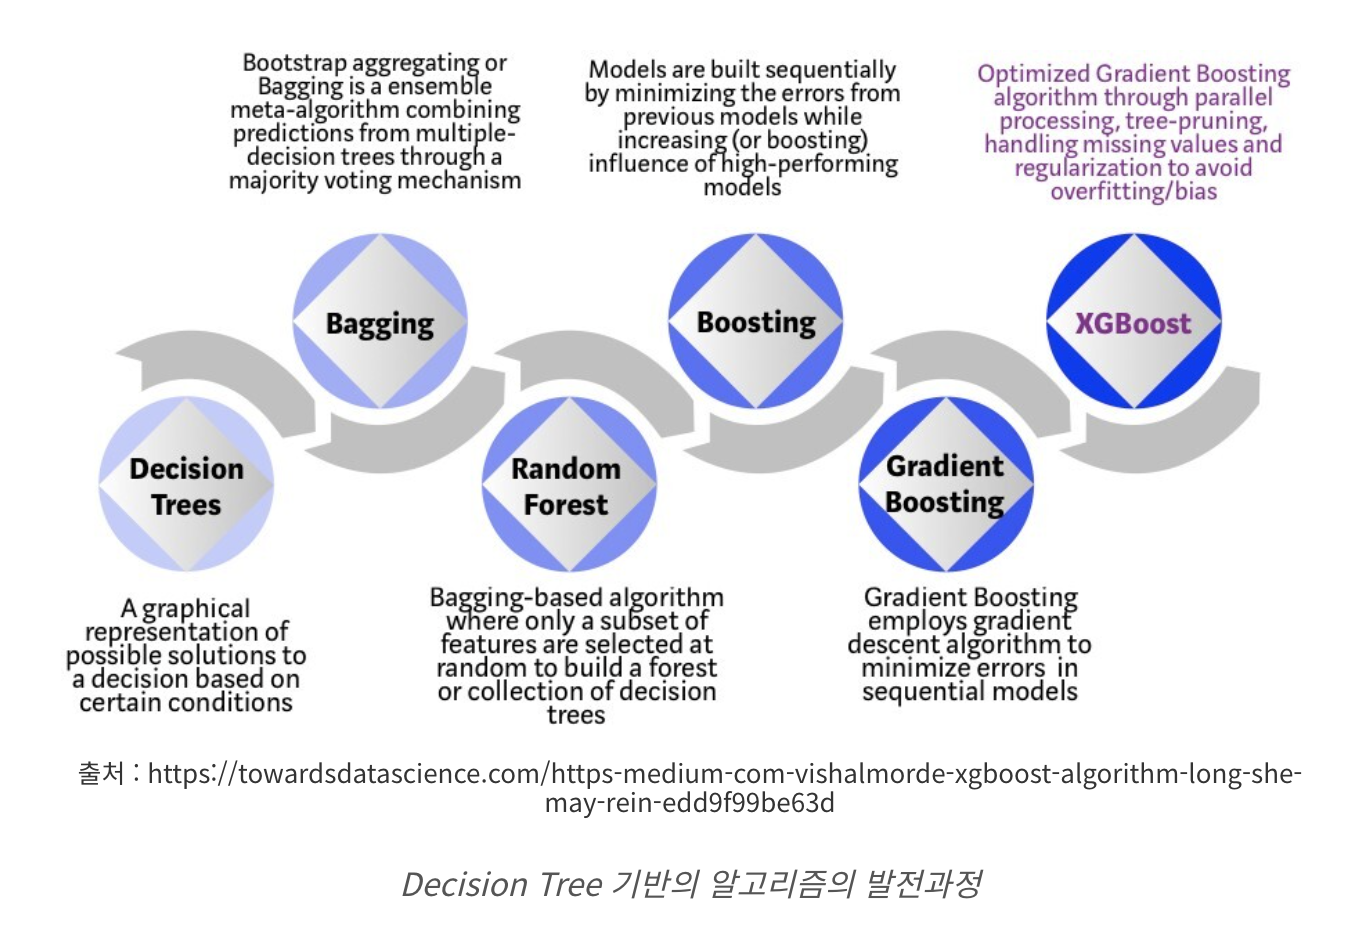